In [20]:
import numpy as np
import copy
from matplotlib import pyplot as plt
import matplotlib.animation
from functools import partial 
import time
from datetime import timedelta
from IPython.display import clear_output
from ipywidgets import *
import math
import numpy.matlib
import imageio
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = [8,8]
%matplotlib inline

from typing import List, Set, Dict, Tuple, Optional
from abc import ABC, abstractmethod

In [203]:
# Helper function
def max_dict(d, value_index=0, precision = 0.001):
    # returns the argmax (key) and max (value) from a dictionary
    # find max val
    values = np.array(list(d.values()))[:,value_index]
    
    max_val = np.max(values)
    
    # find keys corresponding to max val
    max_keys = [key for key, val in d.items() if abs(val[value_index] - max_val) < precision]

    return np.random.choice(max_keys), max_val

def update(epochs=2000, s=500, v=0, plot=False):

    x = np.arange(2*epochs)

    e = np.exp(1)
    y = np.power(x, 0.25)
    #y = np.sqrt(x)
    epsilon = -1/(1+y) * np.log(e/(1 + y))
    epsilon += 2*np.exp(-(x**2/(s**2)))
    max = np.max(epsilon)
    epsilon /= max
    s = np.where(epsilon == 1)
    s = s[0][0]
    epsilon = epsilon[s:epochs+s]
    
    min = np.min(epsilon)

    n = np.isclose(0.5, epsilon, atol=1e-3)
    n = np.where(n==True)[0][0]

    if plot:
        yv = epsilon[v]
        plt.plot(epsilon);
        plt.axvline(x = n, color = 'b', linestyle ="--", alpha=0.5);
        plt.axvline(x = v, color = 'k',linestyle =":", alpha=0.5);
        plt.axhline(yv, color = 'k', linestyle ="--", alpha=0.5);
        plt.axhline(0.5, color = 'b', linestyle ="--", alpha=0.5);
        plt.axhline(min, color = 'g',linestyle ="--", alpha=0.5);
        plt.xticks([0, v, n]);
        plt.yticks([1, 0.5, yv, min]);
    else:
        return epsilon 

def plot_epsilon(epochs, s):
    s_max = int(epochs * 0.9)
    s_min = int(epochs * 0.1)
    if s < s_min:
        s = s_min

    interact(update, epochs= widgets.IntSlider(value=epochs, min=0, max=10000, step=1),
             s= widgets.IntSlider(value=s, min=s_min, max=s_max, step=1), 
             v= widgets.IntSlider(value=0, min=0, max=epochs, step=1), plot=True);

def smooth_epsilon_generator(epochs, s):
    epsilon = update(epochs, s)
    for e in epsilon:
        yield e


def adjust_learning_rate(epochs=1000, min_lr=0.00001, initial_lr=0.01, plot=False):
    """e
    Sets the learning rate
    """
    lr_g = learning_rate_generator(epochs, min_lr, initial_lr)
    lr = []
    for epoch in range(0, epochs):
        lr.append(next(lr_g))

    if plot:
        plt.plot(lr);
        plt.axhline(initial_lr, color = 'k', linestyle ="--", alpha=0.5);
        plt.axhline(min_lr, color = 'g',linestyle ="--", alpha=0.5);
        #plt.xticks([0, v, n]);
        #plt.yticks([1, 0.5, yv, min]);
    else:
        return lr

def learning_rate_generator(epochs=1000, min_lr=0.00001, initial_lr=0.01):
    updated_lr = initial_lr
    epoch = 0
    while epoch < epochs:
        if updated_lr < min_lr:
            updated_lr = min_lr
        yield updated_lr
        epoch += 1
        updated_lr = initial_lr * ( 1 - (epoch / epochs))**2

def plot_learning_rate(epochs):

    interact(adjust_learning_rate,
             epochs= widgets.IntSlider(value=epochs, min=1, max=200000, step=1),
             min_lr= widgets.FloatSlider(value=0.0001, min=0.00001, max=0.001, step=0.00001, readout_format='.5f'), 
             initial_lr= widgets.FloatSlider(value=0.001, min=0.0001, max=0.01, step=0.0001, readout_format='.5f'),
             plot=True);

In [204]:
plot_learning_rate(30000)

interactive(children=(IntSlider(value=30000, description='epochs', max=200000, min=1), FloatSlider(value=0.000…

In [131]:
num_epochs = 6000
sigma = int(num_epochs * 0.2)

plot_epsilon(num_epochs, sigma)

#for e in epsilon_generator(num_epochs, sigma):
#    print(e)

interactive(children=(IntSlider(value=6000, description='epochs', max=10000), IntSlider(value=1200, descriptio…

In [4]:
class Maze:
    def __init__(self, ll: Optional[List[List]]):
        if ll:
            self.maze = np.array(ll)
            self.rows, self.columns = self.maze.shape
        self.start = None
        self.exits = set()
        self.traps = set()
        self.walls = set()
        self.cells = {"path": (0,"yellow"),
                      "wall": (1,"black"),
                      "start": (2,"grey"),
                      "exit": (3, "green"),
                      "trap": (4, "red")}
        for i in range(self.rows):
            for j in range(self.columns):
                if self.maze[i,j] == 1:
                    self.walls.add((i,j))
    
    def __getitem__(self, item):
        i = item[0]
        j = item[1]
        assert i>=0 and i<self.rows
        assert j>=0 and j<self.columns
        return self.maze[i, j]
    
    def __setitem__(self, idx, val):
        pass
        
    def set_start(self, start: Tuple[int, int]):
        '''
        Set the (unique)starting location in the maze.
        '''
        i, j = start
        if self.maze[i,j] == 0:
            self.start = (i, j)
        else:
            print(f"Invalid starting location")

    def set_trap(self, traps: List[Tuple[int, int]]):
        self.set_exit(traps, trap=True)
        
    def set_exit(self, exits: List[Tuple[int, int]], trap=False):
        if self.start == None:
            print("Set the starting point first")
        else:
            rows, columns = self.maze.shape
            max_i = self.rows - 1
            max_j = self.columns - 1
            for (i, j) in exits:
                if i < 0 or i > max_i or j < 0 or j > max_j:
                    print(f"Invalid position on the maze {(i,j)}") 
                    return
                if (i,j) == self.start:
                    self.exits = set()
                    print(f"An exist can not be the starting location")
                    return
                if self.maze[i, j] in self.walls:
                    print("This position is in a wall!")
                    self.exits = set()
                    return
                i_ = 0 if i == max_i else i 
                j_ = 0 if j == max_j else j 
                match (i_,j_):
                    case (0, _) | (_, 0):
                        if trap == True:
                            self.traps.add((i, j))
                            self.maze[i, j] = self.cells["trap"][0]
                        else:
                            self.exits.add((i, j))
                    case _:
                        if trap == True:
                            self.traps.add((i, j))
                            self.maze[i, j] = self.cells["trap"][0]
                        else:
                            print(f"An exist must be on the border of the maze")
                            return          
        
    def show(self, pos=None):
        maze = self.maze.copy()
        fig, ax = plt.subplots(1,1)
        ax.grid( which='major')

        colours = self.cells
        
        if self.start != None:
            maze[*self.start] = colours["start"][0]
            for exit in self.exits:
                maze[*exit] = colours["exit"][0]
            for trap in self.traps:
                maze[*trap] = colours["trap"][0]

        if pos != None:
            colours["pos"] = (5,'blue')
            maze[*pos] = colours["pos"][0]

        colors = [c for (_,c) in colours.values()]
        if self.traps == set():
            colors = colors[:-1]

        cell_types = list(colours.keys())
        cmap = ListedColormap(colors)
        Z = maze[::-1]
        ax.pcolormesh(Z, cmap=cmap, edgecolors='k', alpha=0.8)
        patches = [mpatches.Patch(color=colors[i], label="{t}".format(t=cell_types[i])) for i in range(len(colors))]
        
        ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        
    # TODO: add function to read the maze from a file



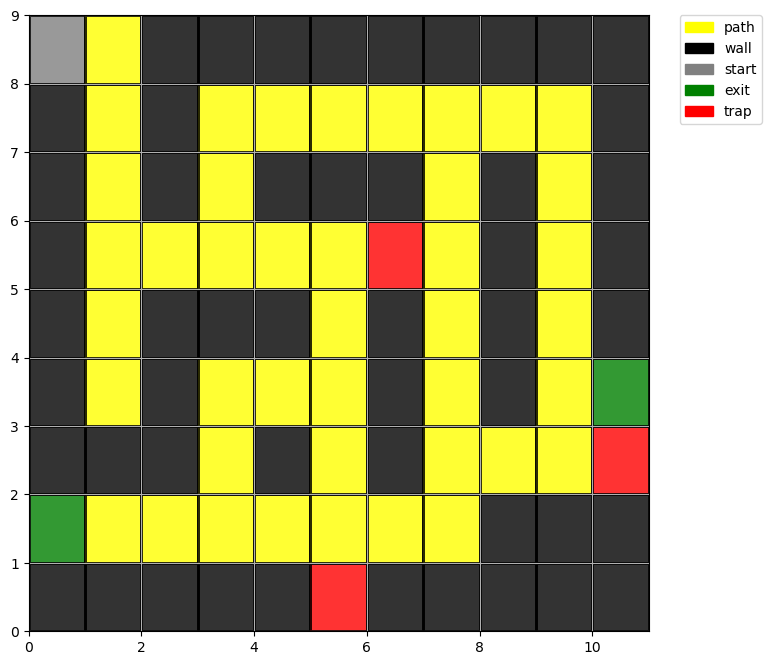

In [5]:
maze = Maze([[0,0,1,1,1,1,1,1,1,1,1],
            [1,0,1,0,0,0,0,0,0,0,1],
            [1,0,1,0,1,1,1,0,1,0,1],
            [1,0,0,0,0,0,1,0,1,0,1],
            [1,0,1,1,1,0,1,0,1,0,1],
            [1,0,1,0,0,0,1,0,1,0,0],
            [1,1,1,0,1,0,1,0,0,0,0],
            [0,0,0,0,0,0,0,0,1,1,1],
            [1,1,1,1,1,0,1,1,1,1,1]])

maze.set_start([0,0])
maze.set_exit([(5,10),(7,0)])
maze.set_trap([(6,10), (8, 5), (3,6)])
maze.show()

In [6]:
%%script false --no-raise-error
# The previous line is to deactivate this cell

maze = Maze([[0,0,1,1,1,1,1],
             [1,0,1,0,1,1,1],
             [1,0,1,0,1,1,1],
             [1,0,0,0,0,0,1],
             [1,1,1,1,1,0,1],
             [1,1,1,1,1,0,0],
             [1,1,1,1,1,1,1]])

maze.set_start([0,0])
maze.set_exit([(5,6)])
maze.show()

In [7]:
class MazeEnvironment:
    '''
    The maze is a grid where each position has an id.
    e.g for a 2 by 3 maze, the ids of the cells are:
    0 1 2
    4 5 6
    '''
    def __init__(self, maze: Maze, slipping_probability=0):
        # slipping_probability is the probability of ending in the trap when passing nearby
        self.prob_slipping = slipping_probability
        self.maze = maze
        self.current_state = self.state_id(*maze.start)
        self.actions = ('E','N','W','S')
        self.invalid_action = -1
        self.game_over = False
        self.start_state = self.state_id(*self.maze.start)
        self.end_states = []
        self.trap_states = []
        self.valid_states = []
        # Register the valid positions on the maze
        for row in range(self.maze.rows):
            for column in range(self.maze.columns):
                if (row, column) not in self.maze.walls:
                    self.valid_states.append(self.state_id(row, column))
        # Register the exits
        for exit in self.maze.exits:
            self.end_states.append(self.state_id(*exit))
        # Register the traps
        for trap in self.maze.traps:
            self.trap_states.append(self.state_id(*trap))
        
    def reset(self, start_state=None):
        '''
        Reset the current state and the status of the game.
        It is possible to force the start state to any valid state
        '''
        if start_state != None and start_state not in self.maze.exits:
            self.current_state = start_state
        else:
            self.current_state = self.start_state
        self.game_over = False
 
    def grid_pos(self, s=None):
        '''
        Returns the position (i, j) of a state with id s.
        (i.e this is the inverse of state_id())
        '''
        if s == None:
            s = self.current_state
        nr = self.maze.rows
        nc = self.maze.columns
        i = s // nc
        j = s - nc*i
        assert j>= 0 and j<self.maze.columns
        return (i,j)
    
    def state_id(self, i, j):
        '''
        i: line number of the grid
        j: column number of the grid
        Returns the cell's number (that is the state id) for
        a cell at line i and column j.
        '''
        N = self.maze.columns
        return N*i + j
    
    def neighbor_states(self, state=None):
        '''
        Get the neighbor states ids of a state s.
        Invalid neighbor have id -1.
        '''
        def valid_neighbor(i, j):
            '''
            Return False if the neigbor cell is a wall
            '''
            if (i, j) in self.maze.walls:
                return False
            return True

        if state== None:
            state = self.current_state
            
        i, j = self.grid_pos(state)
        max_row = self.maze.rows - 1
        max_col = self.maze.columns - 1
        
        north = self.state_id(i-1, j) if (i>0 and valid_neighbor(i-1,j)) else self.invalid_action
        east = self.state_id(i, j+1) if (j<max_col and valid_neighbor(i,j+1)) else self.invalid_action
        south = self.state_id(i+1, j) if (i<max_row and valid_neighbor(i+1,j)) else self.invalid_action
        west = self.state_id(i,j-1) if (j>0 and valid_neighbor(i,j-1)) else self.invalid_action
        return {'N': north, 'E': east, 'S': south, 'W': west}

    def is_near_trap(self, state):
        '''
        Returns True if a cell touch a trap cell.
        '''
        i, j = self.grid_pos(state)
        max_row = self.maze.rows - 1
        max_col = self.maze.columns - 1
        
        north = self.state_id(i-1, j) if (i>0) else self.invalid_action
        east = self.state_id(i, j+1) if (j<max_col) else self.invalid_action
        south = self.state_id(i+1, j) if (i<max_row) else self.invalid_action
        west = self.state_id(i,j-1) if (j>0) else self.invalid_action
        surrounding_cells = [north, east, south, west]
        for trap in self.trap_states:
            if trap in surrounding_cells:
                return True
        return False
        
    def update_state(self, action):
        '''
        Update the state if the action is valid and return a reward.
        '''
        assert action in self.actions
        reward = -1
        current_state = self.current_state
        
        assert current_state not in self.end_states
        assert current_state not in self.trap_states

        nbg_states = self.neighbor_states(current_state)
        next_state = nbg_states[action]
        
        if next_state == self.start_state:
            # Back to starting point
            reward = -500
        elif next_state == self.invalid_action:
            # Hitting a wall
            next_state = current_state
            reward = -100
        elif next_state in self.trap_states:
            # Entering a trap
            reward = -5000
            self.game_over = True
        elif next_state not in self.end_states:
            if self.prob_slipping != 0:
                # It's a dangerous world...
                # Passing near a trap is dangerous. They act like black holes.
                # So, if next state is near a trap there is a chance to fall in it.
                slip = np.random.binomial(1, self.prob_slipping)
                if slip == 1 and self.is_near_trap(next_state):
                    # Slip in the trap
                    reward = -5000
                    self.game_over = True

        if not self.game_over and next_state in self.end_states:
            assert reward == -1
            reward = 1000
            self.game_over = True

        self.current_state = next_state
        return reward
        
    def get_state(self):
        return self.current_state
        

In [393]:
class MazeAgent(ABC):
    def __init__(self, maze_env: MazeEnvironment):
        self.gamma = 1
        self.episode = []
        self.maze_env = maze_env
        self.Q = {}
        self.policy = {}
        self.reward_per_episode = []
        non_exit_states = np.setdiff1d(self.maze_env.valid_states, self.maze_env.end_states)
        self.non_exit_states = np.setdiff1d(non_exit_states, self.maze_env.trap_states)
        
    def reset(self):
        self.episode = []
        self.policy = {}
        self.Q = {}
        self.V = {}
        # Reset Q and the policy
        for state in self.maze_env.valid_states:
            self.V[state] = 0.
            self.Q[state] = {}
            self.policy[state] = np.random.choice(self.maze_env.actions)
            for action in self.maze_env.actions:
                # Store the value and the number of time the action was selected
                self.Q[state][action] = (0.0, 0) 

    def reset_episode_(self, weights, episodes, total_episodes):
        self.episode = []
        self.maze_env.reset()
        
    def reset_episode(self, weights, episodes, total_episodes, m=0.2):
        self.episode = []
        # Select a start position
        if episodes < total_episodes * m: 
            states_selection_distribution = np.reciprocal(weights)
            states_selection_distribution = states_selection_distribution / np.sum(states_selection_distribution)
            start_state = np.random.choice(self.non_exit_states, p=states_selection_distribution)
            weight_idx = np.where(self.non_exit_states == start_state)[0][0]
            weights[weight_idx] += 1
            self.maze_env.reset(start_state)
        else:
            self.maze_env.reset()
        return weights

    def update_epsilon(self, epsilon):
        if epsilon > 0.2:
                epsilon *= 0.9997
        elif epsilon > 0.05:
            epsilon *= 0.9995
        return epsilon
        
    def set_gamma(self, gamma):
        self.gamma = gamma

    @abstractmethod
    def epsilon_greedy(self, s, eps):
        '''
        Epsilon-greedy policy
        '''
        raise NotImplementedError("Must override epsilon_greedy")
 
    @abstractmethod
    def boltzmann(self, s, tau):
        '''
        Boltzmann policy
        '''
        raise NotImplementedError("Must override boltzmann")
        
    def take_action(self, policy, param=0.5):
        '''
        policy can be either epsilon_greedy or boltzmann.
        '''
        state = self.maze_env.get_state()
        action = policy(state, param)

        reward = self.maze_env.update_state(action)
        self.episode.append(((state, action), reward))

    @abstractmethod
    def run_episodes(self, epsilon_generator=smooth_epsilon_generator, s=100, episode_max_length=500, total_episodes=1000):
        pass     

    def get_path(self):
        path = [self.maze_env.start_state]
        while True:
            current_pos = path[-1]
            next_step = self.policy[current_pos]
            next_pos = self.maze_env.neighbor_states(current_pos)[next_step]
            if next_pos in path:
                print("Loop!")
                break #We entered a loop
            if next_pos == -1:
                print(f"Hit a wall!")
                break
            path.append(next_pos)
            if next_pos in self.maze_env.end_states or next_pos in self.maze_env.trap_states:
                break
        return path

    
    def plot_maze(self, ax):
        colours = self.maze_env.maze.cells
        
        colors = [c for (_,c) in colours.values()]
        if self.maze_env.trap_states == []:
            colors = colors[:-1]
        
        Z = np.zeros([self.maze_env.maze.rows, self.maze_env.maze.columns])
        rows = self.maze_env.maze.rows
        for s in range(self.maze_env.maze.rows * self.maze_env.maze.columns):
            (i,j) = self.maze_env.grid_pos(s)
            #i = rows - 1 - i
            if s not in self.maze_env.valid_states:
                Z[i, j] = colours["wall"][0]
            if s in self.maze_env.end_states:
                Z[i, j] = colours["exit"][0]
            if s in self.maze_env.trap_states:
                Z[i, j] = colours["trap"][0]
            if s == self.maze_env.start_state:
                Z[i, j] = colours["start"][0]

        cmap = ListedColormap(colors)
        ax.pcolormesh(Z[::-1], cmap=cmap, edgecolors='k', alpha=0.6)

    
    def plot_policy(self, path_only=True, ax=None):
        rows = self.maze_env.maze.rows
        columns = self.maze_env.maze.columns
        if ax == None:
            m = max(rows, columns)
            width = int(6 * float(columns)/m)
            height = int(6 * float(rows)/m)
            fig, ax = plt.subplots(1,1,figsize=(width, height))

        ax.set_xticks(np.arange(1, columns, 1))
        ax.set_yticks(np.arange(0, rows, 1))
        ax.grid( which='major')
        
        # plot the background (i.e the maze)
        self.plot_maze(ax)
        
        # Show the path from start to end
        path = self.get_path()
        
        for s, d in self.policy.items():
            i, j = self.maze_env.grid_pos(s)
            x = j + 0.5
            y = self.maze_env.maze.rows - i - 0.5
            if s in path:
                c = mpatches.Circle((x, y), 0.2, alpha=0.6, ec="none", fc='lime')
                ax.add_artist(c)
            elif path_only == True:
                # Plot only the path
                continue
            # Draw arrows
            if s in self.maze_env.end_states:
                continue
            if s in self.maze_env.trap_states:
                continue
            match d:
                case 'E':
                    dx = 0.8
                    dy = 0
                case 'S':
                    dx = 0.
                    dy = -0.8
                case 'W':
                    dx = -0.8
                    dy = 0
                case 'N':
                    dx = 0
                    dy = 0.8
            
            param = {'lw':3, 'head_width':1/10}
            ax.arrow(x, y, dx, dy, **param)
            ax.text(x-0.4, y+0.3, f'{s}', color='purple', fontsize=6)

        
    def plot_walk(self):

        rows = self.maze_env.maze.rows
        columns = self.maze_env.maze.columns
        m = max(rows, columns)
        width = int(6 * float(columns)/m)
        height = int(6 * float(rows)/m)
        
        plt.rcParams["animation.html"] = "jshtml"
        plt.rcParams['figure.dpi'] = 150  
        plt.ioff()
        fig, ax = plt.subplots(1,1,figsize=(width, height))

        ax.set_xticks(np.arange(1, columns, 1))
        ax.set_yticks(np.arange(0, rows, 1))
        ax.grid( which='major')
 
        # plot the background (i.e the maze)
        self.plot_maze(ax)

        # Get the path from start to end
        path = self.get_path()
        
        steps = len(path)
        
        def step(k):
            s = path[k]
            i, j = self.maze_env.grid_pos(s)
            x = j + 0.5
            y = self.maze_env.maze.rows - i - 0.5
            c = mpatches.Circle((x, y), 0.2, alpha=0.6, ec="none", fc='lime')
            ax.add_artist(c)

        walk =  matplotlib.animation.FuncAnimation(fig, step, frames=steps)
        return walk
                    

In [394]:
class MC_MazeAgent(MazeAgent):
    def __init__(self, maze_env: MazeEnvironment):
        super().__init__(maze_env)

    def epsilon_greedy(self, s, eps):
            p = np.random.random()
            if p < (1 - eps):
                return self.policy[s]
            return np.random.choice(self.maze_env.actions)

    def boltzmann(self, s, tau=1):
        pass
    
    def run_episodes(self, epsilon_generator=epsilon_generator, s=100, episode_max_length=500, total_episodes=1000):
        self.reset()
        episodes = 0
        weights = np.ones(len(self.non_exit_states))
        
        epsilons = epsilon_generator(total_episodes, s)

        self.reward_per_episode = []
        episodes_durations = []
        average_duration_str = ""
        
        while episodes != total_episodes:
            epsilon = next(epsilons)
            start = time.time()
            
            #if episodes % 100 == 0:
            #    print(f"Episodes number {episodes}. Epsilon = {epsilon:.3f}" + average_duration_str)
            #    episodes_durations = []
                
            # Reset for an episode
            weights = self.reset_episode(weights, episodes, total_episodes)
            
            # Starting state for this episode
            start_state = self.maze_env.get_state()
            
            # Run an episode             
            episode_reward = 0   
            current_episode_counter = episode_max_length
            while (self.maze_env.game_over == False) and current_episode_counter:
                self.take_action(self.epsilon_greedy, epsilon)
                current_episode_counter -=1
                
            # Once the episode is finished, we can update the Q table and the policy
            G = 0
            reversed_episode = self.episode[::-1]
            states_actions = []
            for ((state, action), reward) in reversed_episode:
                G = reward + self.gamma * G
                episode_reward += reward
                if (state, action) not in states_actions:
                    states_actions.append((state, action)) # "First Visit"
                    old_q = self.Q[state][action]
                    sample_count = old_q[1] + 1
                    lr = 1 / sample_count
                    value = old_q[0]
                    value = value + lr * (G - value)
                    self.Q[state][action] = (value, sample_count)
                
                # Update the policy for state s
                self.policy[state] = max_dict(self.Q[state], 0)[0]

            if start_state == self.maze_env.start_state:
                # We are interested only in episode that started at the 'start_state'
                self.reward_per_episode.append(episode_reward)
                
            episodes += 1
            end = time.time()
            episodes_durations.append(timedelta(seconds=end-start))
            #average_duration_str = f", Average duration: {np.mean(episodes_durations)}"

        print(f"Episodes number {episodes}. Epsilon = {epsilon:.3f}, "
              f"Average duration: {np.mean(episodes_durations)}")
               
        # Update the policy
        for state in self.non_exit_states:
            self.policy[state] = max_dict(self.Q[state], 0)[0]

        return weights
           

In [395]:
mc_maze_env = MazeEnvironment(maze, 0.5)
mc_maze_agent = MC_MazeAgent(mc_maze_env)
mc_maze_agent.set_gamma(0.98)

start = time.time()
weights = mc_maze_agent.run_episodes(s=1600, episode_max_length=5000, total_episodes=5500)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Episodes number 5500. Epsilon = 0.063, Average duration: 0:00:00.001324
Elapsed time: 0:00:07.323622


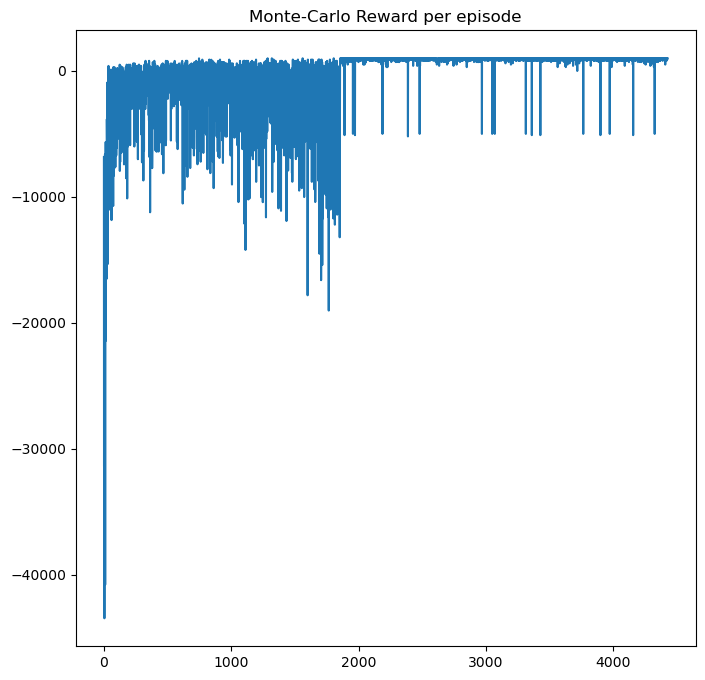

In [396]:
plt.plot(mc_maze_agent.reward_per_episode)
plt.title("Monte-Carlo Reward per episode");

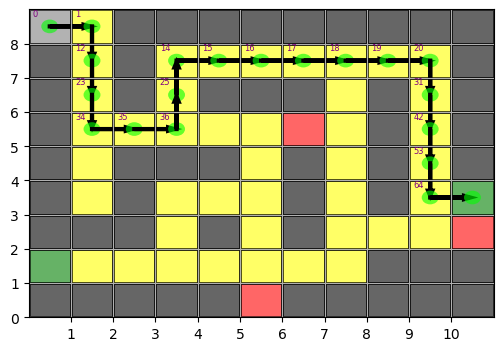

In [397]:
mc_maze_agent.plot_policy()

In [13]:
%%script false --no-raise-error
states_selection_distribution = np.reciprocal(weights)
states_selection_distribution = weights / np.sum(weights)
plt.scatter(x=range(len(mc_maze_agent.non_exit_states)), y=states_selection_distribution)

In [398]:
class SARSA_MazeAgent(MazeAgent):
    def __init__(self, maze_env: MazeEnvironment, lr=0.1):
        super().__init__(maze_env)
        self.lr = lr
        self.reward_per_episode = []

    def epsilon_greedy(self, s, eps):
        p = np.random.random()
        if p < (1 - eps):
            return self.policy[s]
            #return max_dict(self.Q[s], 0)[0]
        return np.random.choice(self.maze_env.actions)
    
    def boltzmann(self, s, tau=1):
        pass
        
    def run_episodes(self, epsilon_generator=smooth_epsilon_generator, s=100, episode_max_length=500, total_episodes=1000):
        self.reset()
        episodes = 0
        self.reward_per_episode = []
        weights = np.ones(len(self.non_exit_states))
        
        epsilons = epsilon_generator(total_episodes, s)
        
        while episodes != total_episodes:

            epsilon = next(epsilons)
            
            # Reset for an episode
            weights = self.reset_episode(weights, episodes, total_episodes)
            
            # Run an episode
            episode_reward = 0    
            current_episode_counter = episode_max_length
            self.take_action(self.epsilon_greedy, epsilon)
            (s, a), r = self.episode[-1]
            if (self.maze_env.game_over == True):
                old_q = self.Q[s][a]
                value = old_q[0]
                sample_count = old_q[1] + 1
                value = value + self.lr * r
                self.Q[s][a] = (value, sample_count)
            
            while (self.maze_env.game_over == False) and current_episode_counter:
                current_episode_counter -=1
                episode_reward += r
                #current_state = self.maze_env.get_state()
                self.take_action(self.epsilon_greedy, epsilon)
                (s2, a2), r2 = self.episode[-1]
                #assert s2 == current_state
                old_q = self.Q[s][a]
                value = old_q[0]
                sample_count = old_q[1] + 1
                next_q = self.Q[s2][a2]
                value = value + self.lr * (r + self.gamma * next_q[0] - value)
                #value = value + self.lr * (r + self.gamma * r2 - value)
                self.Q[s][a] = (value, sample_count)
                # Update the policy for state s
                self.policy[s] = max_dict(self.Q[s], 0)[0]
                s = s2
                a = a2
                r = r2
                
            self.reward_per_episode.append(episode_reward)       
            episodes += 1

        # Update the policy
        for state in self.non_exit_states:
            self.policy[state] = max_dict(self.Q[state], 0)[0]
            
        print(f"Epsilon: {epsilon}")
           

In [399]:
sarsa_maze_env = MazeEnvironment(maze, 0.5)
sarsa_maze_agent = SARSA_MazeAgent(sarsa_maze_env, 0.2)
sarsa_maze_agent.set_gamma(0.9)

start = time.time()
sarsa_maze_agent.run_episodes(s=650, episode_max_length=10000, total_episodes=5500)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Epsilon: 0.06343444772467843
Elapsed time: 0:00:04.688990


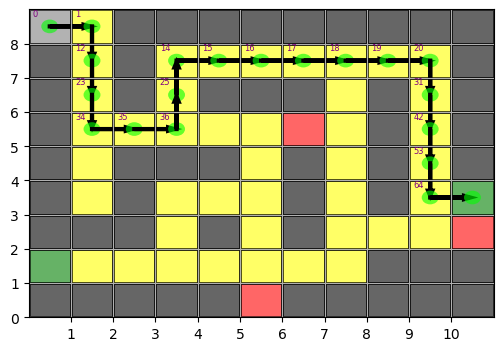

In [400]:
sarsa_maze_agent.plot_policy()

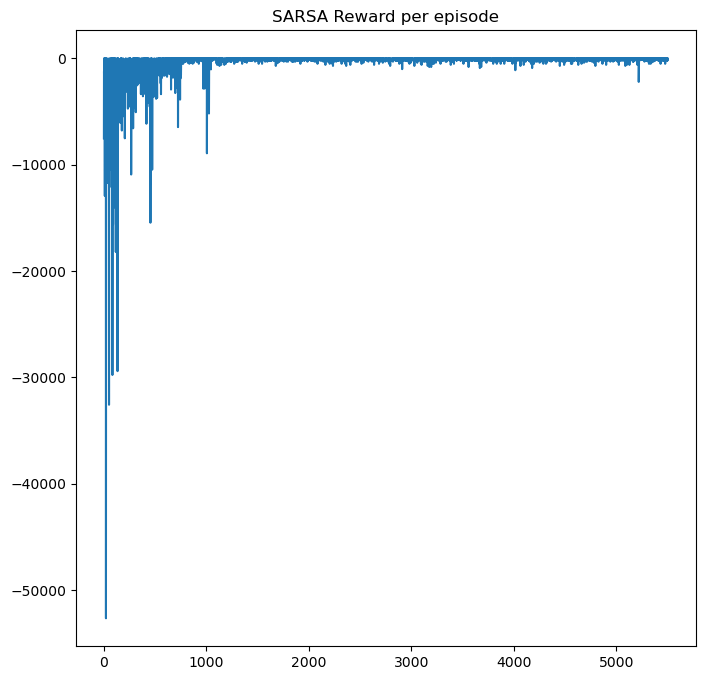

In [401]:
plt.plot(sarsa_maze_agent.reward_per_episode)
plt.title("SARSA Reward per episode");

In [18]:
#sarsa_maze_agent.plot_walk()

In [402]:
class QL_MazeAgent(MazeAgent):
    def __init__(self, maze_env: MazeEnvironment, lr=0.1):
        super().__init__(maze_env)
        self.lr = lr
        self.reward_per_episode = []

    def epsilon_greedy(self, s, eps):
        p = np.random.random()
        if p < (1 - eps):
            return self.policy[s]
            #return max_dict(self.Q[s], 0)[0]
        return np.random.choice(self.maze_env.actions)
        
    def boltzmann(self, s, tau=1):
        pass
    
    def run_episodes(self, epsilon_generator=smooth_epsilon_generator, s=100, episode_max_length=500, total_episodes=1000):
        self.reset()
        episodes = 0
        self.reward_per_episode = []
        weights = np.ones(len(self.non_exit_states))

        epsilons = epsilon_generator(total_episodes, s)
        
        while episodes != total_episodes:
            # Reset for an episode
            weights = self.reset_episode(weights, episodes, total_episodes)
            
            # Run an episode
            episode_reward = 0
            current_episode_counter = episode_max_length
            
            epsilon = next(epsilons)
            
            while (self.maze_env.game_over == False) and current_episode_counter:
                
                current_episode_counter -=1
                self.take_action(self.epsilon_greedy, epsilon)
                (s, a), r = self.episode[-1]
                episode_reward += r
                old_q = self.Q[s][a]
                value = old_q[0]
                sample_count = old_q[1] + 1
                s2 = self.maze_env.get_state()
                _, max_q = max_dict(self.Q[s2], 0)
                value = value + self.lr * (r + self.gamma * max_q - value)
                self.Q[s][a] = (value, sample_count)
                # Update the policy for state s
                self.policy[s] = max_dict(self.Q[s], 0)[0]
                
            self.reward_per_episode.append(episode_reward)       
            episodes += 1
        
        # Update the policy
        for state in self.non_exit_states:
            self.policy[state] = max_dict(self.Q[state], 0)[0]
            
        print(f"Epsilon: {epsilon}")
           

In [403]:
ql_maze_env = MazeEnvironment(maze, 0.5)
ql_maze_agent = QL_MazeAgent(ql_maze_env, 0.2)
ql_maze_agent.set_gamma(0.9)

ql_maze_agent.run_episodes(s=600, episode_max_length=10000, total_episodes=5000)

Epsilon: 0.06379076518821433


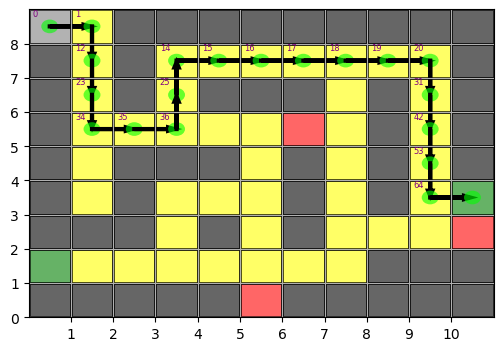

In [405]:
ql_maze_agent.plot_policy()

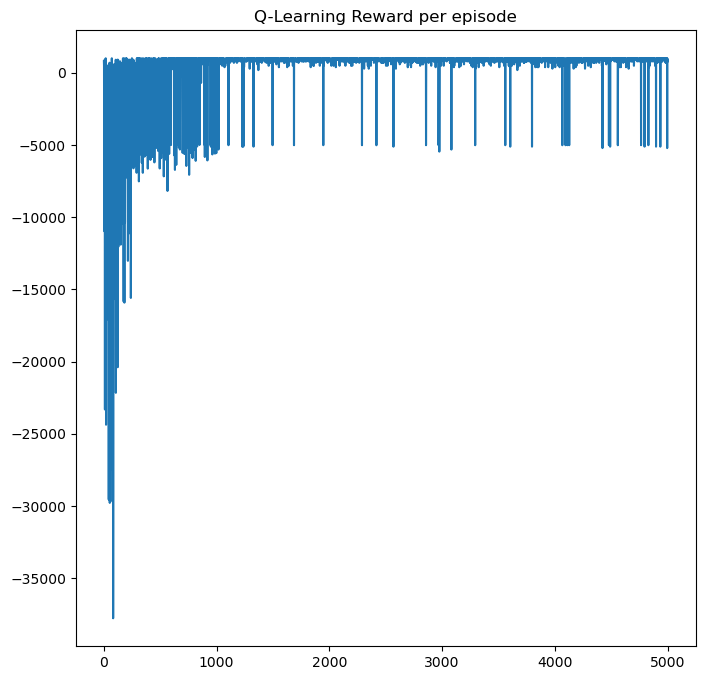

In [406]:
plt.plot(ql_maze_agent.reward_per_episode)
plt.title("Q-Learning Reward per episode");

In [23]:
from sklearn.kernel_approximation import Nystroem, RBFSampler

In [404]:
class Approximation_QL_MazeAgent(MazeAgent):
    def __init__(self, maze_env: MazeEnvironment, policy_selection=1, lr=0.1):
        super().__init__(maze_env)
        self.lr = lr
        self.samples = []
        self.featurizer = RBFSampler()
        self.w = None
        self.one_hot_encoded_action = np.eye(len(self.maze_env.actions))
        if policy_selection == 0:
            self.pi = self.epsilon_greedy
        else:
            self.pi = self.boltzmann
        
    def epsilon_greedy(self, s, eps):
        p = np.random.random()
        if p < (1 - eps):
            values = self.predict_actions(s)
            return self.maze_env.actions[np.argmax(values)]
        return np.random.choice(self.maze_env.actions)

    def boltzmann(self, s=None, tau=1):
        if s == None:
            s = self.maze_env.get_state()
        values = np.array(self.predict_actions(s))/tau
        max_value = np.amax(values)
        values -= max_value # prevent overflow
        exp_values = np.exp(values) + 0.001 # prevent underflow
        p_b = exp_values/np.sum(exp_values)
        return np.random.choice(self.maze_env.actions, p=p_b)
    
    def merge_s_a(self, s, a):
        # Get the actions's index
        a_idx = self.maze_env.actions.index(a)
        # Get the one-shot encoded action
        encoded_action = self.one_hot_encoded_action[a_idx]
        s = np.array([s])
        return np.concatenate((s, encoded_action))
        
    def gather_samples(self, total_episodes=1000):
        self.samples = []
        weights = np.ones(len(self.non_exit_states))
        for episodes in range(total_episodes):
            self.reset()
            weights = self.reset_episode(weights, episodes, total_episodes)
            # Run an episode
            while (self.maze_env.game_over == False):
                self.take_action(self.epsilon_greedy, 1) # Take a random action
                (s, a), r = self.episode[-1]
                sa = self.merge_s_a(s, a)
                self.samples.append(sa)

    def fit(self, total_episodes=1000):
        self.gather_samples(total_episodes)
        self.featurizer.fit(self.samples)
        dims = self.featurizer.n_components
        # initialize linear model weights
        self.w = np.zeros(dims)

    def predict(self, s, a):
        sa = self.merge_s_a(s, a)
        x = self.featurizer.transform([sa])[0]
        return x @ self.w
 
    def predict_actions(self, s=None):
        if s == None:
            s = self.maze_env.get_state()
        return [self.predict(s, a) for a in self.maze_env.actions]
        
    def gradient(self, target, s, a):
        sa = self.merge_s_a(s, a)
        x = self.featurizer.transform([sa])[0]
        err = target -  x @ self.w
        return err * x

    
    def run_episodes(self, epsilon_generator=smooth_epsilon_generator, s=100, episode_max_length=500, total_episodes=1000, epsilon=1):
        # Make sure fit was done
        assert self.w is not None
        
        self.reset()
        episodes = 0
        self.reward_per_episode = []
        weights = np.ones(len(self.non_exit_states)) # weights for the selection of the start state

        epsilons = epsilon_generator(total_episodes, s)
        
        while episodes != total_episodes:
            
            epsilon = next(epsilons)
            
            if episodes % 500 == 0:
                print(f"Episodes number {episodes}. Epsilon = {epsilon}")
                
            # Reset for an episode
            weights = self.reset_episode(weights, episodes, total_episodes)
            
            # Run an episode
            episode_reward = 0
            current_episode_counter = episode_max_length
            while (self.maze_env.game_over == False) and current_episode_counter:
            
                current_episode_counter -=1
                #self.take_action(self.epsilon_greedy, epsilon)
                self.take_action(self.pi, epsilon)
                (s, a), r = self.episode[-1]
                episode_reward += r
                if (self.maze_env.game_over == True):
                    target = r
                else:
                    v = self.predict_actions()
                    target = r + self.gamma * np.max(v)
                # update the model
                self.w += self.lr * self.gradient(target, s, a)
                
            self.reward_per_episode.append(episode_reward)       
            episodes += 1
        
        # Update the policy
        for state in self.non_exit_states:
            v = self.predict_actions(state)
            self.policy[state] = self.maze_env.actions[np.argmax(v)]
            
        print(f"Epsilon: {epsilon}")
           

In [407]:
small_maze = Maze([[0,0,1,1,1,0,0,1],
                   [1,0,1,1,1,0,1,1],
                   [1,0,0,0,0,0,1,1],
                   [1,0,1,1,1,0,1,1],
                   [1,0,1,0,0,0,0,1],
                   [1,0,1,0,1,1,0,0],
                   [1,0,0,0,1,1,0,0],
                   [1,1,1,1,1,1,1,1]])

small_maze.set_start([0,0])
small_maze.set_exit([(5,7)])

#small_maze.show()

In [408]:
a_ql_maze_env = MazeEnvironment(small_maze)
a_ql_maze_agent = Approximation_QL_MazeAgent(a_ql_maze_env, lr=0.2)
a_ql_maze_agent.set_gamma(0.9)

a_ql_maze_agent.fit()

start = time.time()
a_ql_maze_agent.run_episodes(s=800, episode_max_length=3000, total_episodes=3000)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Episodes number 0. Epsilon = 1.0
Episodes number 500. Epsilon = 0.642789911197583
Episodes number 1000. Epsilon = 0.225793345871313
Episodes number 1500. Epsilon = 0.08561612222270752
Episodes number 2000. Epsilon = 0.06628047624705614
Episodes number 2500. Epsilon = 0.06491879461132546
Epsilon: 0.0646295331002647
Elapsed time: 0:06:48.532574


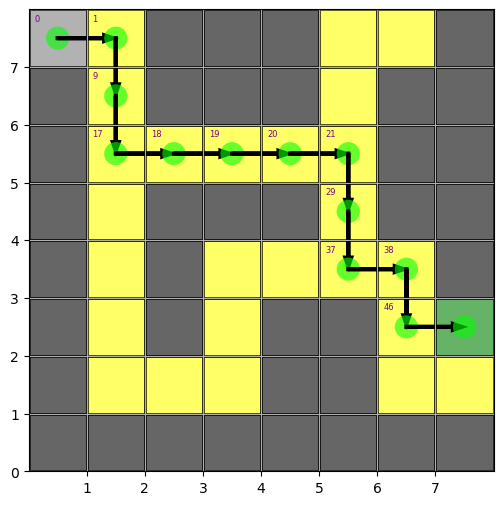

In [410]:
a_ql_maze_agent.plot_policy()

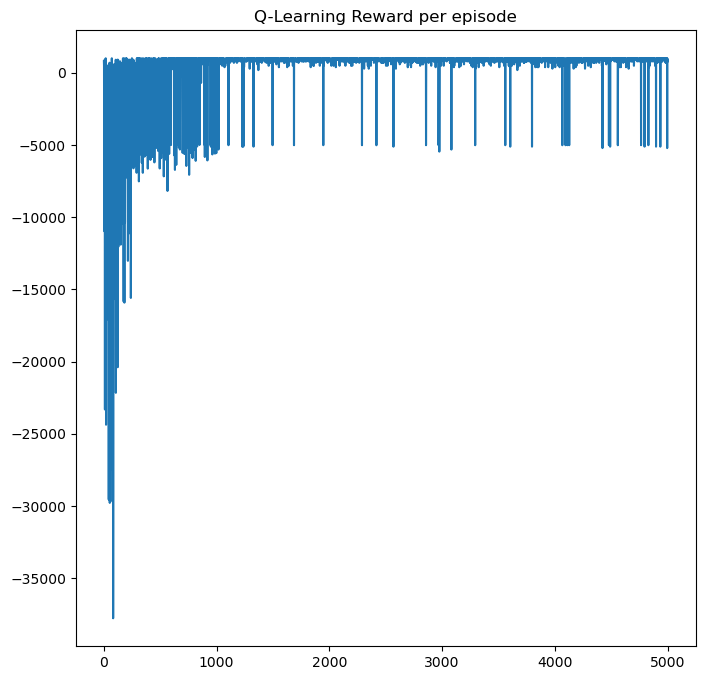

In [411]:
plt.plot(ql_maze_agent.reward_per_episode)
plt.title("Q-Learning Reward per episode");

In [409]:
small_maze_with_trap = Maze([[0,0,1,1,1,0,0,1],
                             [1,0,1,1,1,0,1,1],
                             [1,0,0,0,0,0,1,1],
                             [1,0,1,1,1,0,1,1],
                             [1,0,1,0,0,0,0,1],
                             [1,0,1,0,1,1,0,0],
                             [1,0,0,0,1,1,0,0],
                             [1,1,1,1,1,1,1,1]])

small_maze_with_trap.set_start([0,0])
small_maze_with_trap.set_exit([(5,7)])
small_maze_with_trap.set_trap([(1,3)])
#small_maze_with_trap.show()

In [412]:
a_ql_maze_env_2 = MazeEnvironment(small_maze_with_trap, 0.5)
a_ql_maze_agent_2 = Approximation_QL_MazeAgent(a_ql_maze_env_2, lr=0.2)
a_ql_maze_agent_2.set_gamma(0.9)

a_ql_maze_agent_2.fit()

start = time.time()
a_ql_maze_agent_2.run_episodes(s=1000, episode_max_length=3000, total_episodes=3000)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Episodes number 0. Epsilon = 1.0
Episodes number 500. Epsilon = 0.7455969310369235
Episodes number 1000. Epsilon = 0.36107915824320275
Episodes number 1500. Epsilon = 0.14303338896183293
Episodes number 2000. Epsilon = 0.07735571104893124
Episodes number 2500. Epsilon = 0.06588502234432261
Epsilon: 0.06448949667622507
Elapsed time: 0:11:28.819834


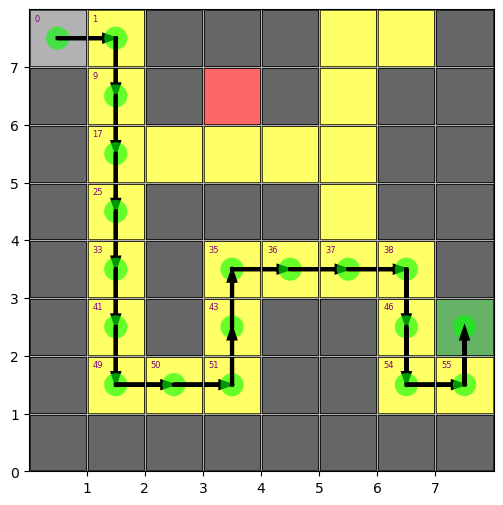

In [413]:
a_ql_maze_agent_2.plot_policy()

In [56]:
a_ql_maze_env_3 = MazeEnvironment(maze, 0.5)
a_ql_maze_agent_3 = Approximation_QL_MazeAgent(a_ql_maze_env_3, lr=0.2)
a_ql_maze_agent_3.set_gamma(0.9)

a_ql_maze_agent_3.fit()

start = time.time()
a_ql_maze_agent_3.run_episodes(s=2000, episode_max_length=6000, total_episodes=4000)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Episodes number 0. Epsilon = 1.0
Episodes number 500. Epsilon = 0.9203553825451111
Episodes number 1000. Epsilon = 0.7493833631145618
Episodes number 1500. Epsilon = 0.5476219093437538
Episodes number 2000. Epsilon = 0.36504795108128435
Episodes number 2500. Epsilon = 0.22927779230049375
Episodes number 3000. Epsilon = 0.14390686387307133
Episodes number 3500. Epsilon = 0.09781682878655953
Epsilon: 0.07624496291426971
Elapsed time: 1:16:52.370768


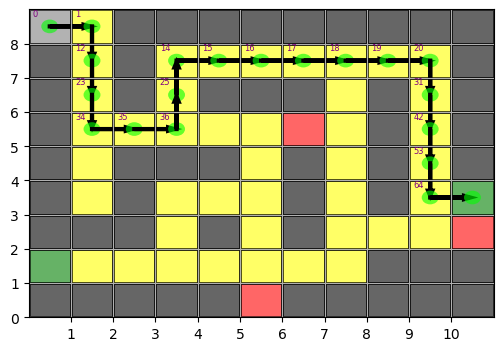

In [57]:
a_ql_maze_agent_3.plot_policy()

In [416]:

import os  
import random 
import torch 
import torch.nn as nn  
import torch.nn.functional as F  
import torch.optim as optim  
from torch.autograd import Variable  


In [417]:
# Creating the architecture of the Neural Network

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, nb_action):
        #super(NeuralNetwork, self).__init__()
        super().__init__()
        self.input_size = input_size 
        self.nb_action = nb_action # Size of the output layer
        self.fc1 = nn.Linear(input_size, 64) # Fully connected 1st layer
        self.fc2 = nn.Linear(64, nb_action) # Fully connected output layer
        
    def forward(self, state): 
        '''
        Forward-propagates the signal inside the neural network and returns the predicted Q-values
        '''
        x = F.relu(self.fc1(state)) 
        q_values = self.fc2(x) 
        return q_values 


In [418]:
# Implementing Experience Replay 

class ReplayMemory:
    def __init__(self, capacity): 
        self.capacity = capacity 
        self.memory = [] 

    def push(self, event):
        #print(f"Push to memeory: {event}")
        self.memory.append(event)
        if len(self.memory) > self.capacity: 
            del self.memory[0]

    
    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size))
        #print(f"samples: {list(samples)}")
        return samples
        #return map(lambda x: torch.cat(x, 0), samples)


In [419]:
# Implementing Deep Q-Learning

class DQN:
    def __init__(self, input_size, nb_action, end_states, gamma):
        self.end_states = end_states
        self.gamma = gamma
        self.batch_size = 64
        self.policy_net = NeuralNetwork(input_size, nb_action)
        self.target_net = NeuralNetwork(input_size, nb_action)
        self.memory = ReplayMemory(capacity = self.batch_size * 100) 
        self.optimizer = optim.Adam(params = self.policy_net.parameters())
        self.tau = 1.
        #print(f"end states: {self.end_states}")
        self.first = True

    def get_next_state_qvalues(self, batch_next_states):
        non_final_mask = np.ones(self.batch_size, dtype=bool)
        non_final_next_states = []
        for i, ns in enumerate(batch_next_states):
            not_final = True
            for es in self.end_states:
                if torch.equal(ns, es):
                    not_final = False
                    non_final_mask[i] = False
                    break
            if not_final:
               non_final_next_states.append(ns)

        non_final_mask = torch.tensor(non_final_mask)
        
        non_final_next_states = torch.stack(non_final_next_states)
        
        next_states_values = torch.zeros(self.batch_size)
        with torch.no_grad():
            qvalues = self.target_net(non_final_next_states)
            next_states_values[non_final_mask] = qvalues.max(1)[0]

        return next_states_values.detach().squeeze(-1)

    
    def learn(self, batch_states, batch_actions, batch_rewards, batch_next_states):
        '''
        This function compute the temporal difference, and accordingly the loss,
        and update the weights with our optimizer in order to reduce that loss.
        parameters:
            batch_states: A batch of input states.
            batch_actions: A batch of actions played.
            batch_rewards: A batch of the rewards received.
            batch_next_states: A batch of the next states reached.
        '''
        batch_len = len(batch_states)
        batch_states = torch.stack(batch_states).view((batch_len,-1))
        batch_actions = torch.stack(batch_actions).view((batch_len,-1)).type(torch.int64) 
        
        # State-action values for the batch
        batch_outputs = self.policy_net(batch_states)
        batch_outputs = batch_outputs.gather(1, batch_actions)

        batch_rewards = torch.cat(batch_rewards)
        next_states_values = self.get_next_state_qvalues(batch_next_states)
        
        batch_targets = batch_rewards + self.gamma * next_states_values
            
        # Update the model with gradiant descent
        td_loss = F.smooth_l1_loss(batch_outputs, batch_targets.unsqueeze(1))
        self.optimizer.zero_grad() #  Put back gradient to 0
        td_loss.backward()
        # gradient-clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        # Update the target net
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
        self.target_net.load_state_dict(target_net_state_dict)
        self.tau = 0.05
        #self.tau = 0.1

    def update(self):
        if len(self.memory.memory) > self.batch_size:
            batch_states, batch_actions, batch_rewards, batch_next_states = self.memory.sample(self.batch_size)
            #print(f"{batch_states, batch_actions, batch_rewards, batch_next_states}")
            self.learn(batch_states, batch_actions, batch_rewards, batch_next_states)


In [420]:
class DQN_MazeAgent(MazeAgent):
    def __init__(self, maze_env: MazeEnvironment, gamma=0.99):
        super().__init__(maze_env)
        self.input_size = int(math.log2(np.max(self.maze_env.valid_states))) + 1
        #self.nb_valid_states = len(self.maze_env.valid_states)
        #self.max_valid_state = np.max(self.maze_env.valid_states)
        self.reward_per_episode = []
        end_states = [self.dec2bin(s) for s in self.maze_env.end_states]
        self.DQN = DQN(self.input_size, 4, end_states, gamma)

    def dec2bin(self, x):
        x = torch.tensor(x)
        mask = 2 ** torch.arange(self.input_size - 1, -1, -1).to(x.device, x.dtype)
        return x.unsqueeze(-1).bitwise_and(mask).ne(0).float()

    def bin2dec(self, b):
        mask = 2 ** torch.arange(self.input_size - 1, -1, -1).to(b.device, b.dtype)
        return torch.sum(mask * b, -1)
    
    def epsilon_greedy(self, state, eps):
        p = np.random.random()
        if p < (1 - eps):
            t_state = self.dec2bin(state)
            qvalues = self.DQN.policy_net(t_state)
            action = torch.argmax(qvalues).detach().cpu().numpy()
            return action.item()
        return random.randint(0, len(self.maze_env.actions) - 1)
    
    def boltzmann(self, s, tau=1):
        probs = F.softmax(self.policy_net(Variable(s))/tau)
        # random draw from the distribution of actions
        action = probs.multinomial(len(probs)) 
        return self.maze_env.actions[action.data[0,0]]
    
    def select_action(self, state, epsilon):
        #return self.boltzmann(self, state, epsilon*0.1)
        return self.epsilon_greedy(state, epsilon)
        
    def take_action(self, epsilon=1):
        state = self.maze_env.get_state()
        t_state = self.dec2bin(state)

        # get the action to perform
        action = self.select_action(state, epsilon)

        maze_env_action = self.maze_env.actions[action]

        reward = self.maze_env.update_state(maze_env_action)
        self.episode.append(((state, action), reward))

        new_state = self.maze_env.get_state()
        t_new_state = self.dec2bin(new_state)

        #print(f"state: {state} -> t_state: {t_state}. Action: {action} -> {maze_env_action}. Reward: {reward}. New state: {new_state} -> {t_new_state}")
        # New entry in the Replay memory
        self.DQN.memory.push((t_state,
                              torch.Tensor([action]),
                              torch.Tensor([reward]),
                              t_new_state))
        # Update the NN
        self.DQN.update()
        
    def run_episodes(self, epsilon_generator=smooth_epsilon_generator, s=100, episode_max_length=500, total_episodes=1000):
        
        self.reset()
        episodes = 0
        self.reward_per_episode = []
        weights = np.ones(len(self.non_exit_states)) # weights for the selection of the start state

        episodes_durations = []
        epsilons = epsilon_generator(total_episodes, s)
        average_duration_str = ""
        while episodes != total_episodes:
            start = time.time()
            
            epsilon = next(epsilons)
            
            if episodes % 100 == 0:
                print(f"Episodes number {episodes}. Epsilon = {epsilon:.3f}" + average_duration_str)
                episodes_durations = []
            
            # Reset for an episode
            weights = self.reset_episode(weights, episodes, total_episodes)

            # Starting state for this episode
            start_state = self.maze_env.get_state()
            
            # Run an episode
            episode_reward = 0
            current_episode_counter = episode_max_length
            while (self.maze_env.game_over == False) and current_episode_counter:
                current_episode_counter -=1
                self.take_action(epsilon)

            for _, r in self.episode:
                episode_reward += r

            if start_state == self.maze_env.start_state:
                # We are interested only in episode that started at the 'start_state'
                self.reward_per_episode.append(episode_reward)
                # Ending state for this episode
                #end_state = self.maze_env.get_state()
                #if end_state in self.maze_env.end_states:
                    #print(f"Won in {episode_max_length - current_episode_counter} moves. Episode Reward: {episode_reward}")
                
            episodes += 1
            end = time.time()
            episodes_durations.append(timedelta(seconds=end-start))
            average_duration_str = f", Average duration: {np.mean(episodes_durations)}"

        print(f"Episodes number {episodes}. Epsilon = {epsilon:.3f}, "
              f", Average duration: {np.mean(episodes_durations)}")
        
        # Update the policy
        for state in self.non_exit_states:
            t_state = self.dec2bin(state)
            qvalues = self.DQN.policy_net(t_state)
            action = torch.argmax(qvalues).detach().cpu().numpy()
            self.policy[state] = self.maze_env.actions[action.item()]


In [421]:
very_small_maze = Maze([[0,0,1,0,0],
                        [1,0,1,0,1],
                        [1,0,0,0,1]])

very_small_maze.set_start([0,0])
very_small_maze.set_exit([(0,4)])
very_small_maze.set_exit([(2,4)])

#very_small_maze.show()

In [422]:
dqn_maze_env = MazeEnvironment(small_maze)
dqn_maze_agent = DQN_MazeAgent(dqn_maze_env, 0.95)

start = time.time()
dqn_maze_agent.run_episodes(s=350, episode_max_length=10000, total_episodes=1000)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Episodes number 0. Epsilon = 1.000
Episodes number 100. Epsilon = 0.895, Average duration: 0:00:00.559359
Episodes number 200. Epsilon = 0.681, Average duration: 0:00:00.131942
Episodes number 300. Epsilon = 0.452, Average duration: 0:00:00.051305
Episodes number 400. Epsilon = 0.271, Average duration: 0:00:00.029580
Episodes number 500. Epsilon = 0.158, Average duration: 0:00:00.028094
Episodes number 600. Epsilon = 0.101, Average duration: 0:00:00.020937
Episodes number 700. Epsilon = 0.077, Average duration: 0:00:00.022111
Episodes number 800. Epsilon = 0.069, Average duration: 0:00:00.019595
Episodes number 900. Epsilon = 0.066, Average duration: 0:00:00.019280
Episodes number 1000. Epsilon = 0.066, , Average duration: 0:00:00.019631
Elapsed time: 0:01:30.358022


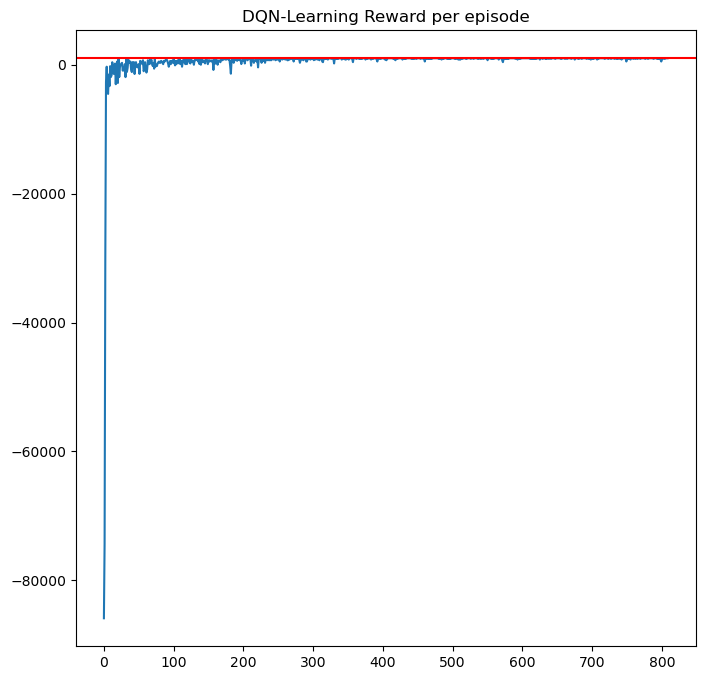

In [423]:
plt.plot(dqn_maze_agent.reward_per_episode)
plt.axhline(1000, color = 'r', label = '100')
plt.title("DQN-Learning Reward per episode");

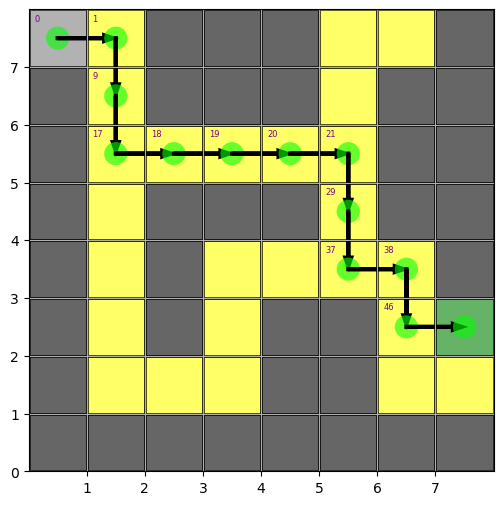

In [424]:

dqn_maze_agent.plot_policy()
#dqn_maze_agent.policy

In [43]:
dqn_maze_env_2 = MazeEnvironment(small_maze_with_trap, 0.5)
dqn_maze_agent_2 = DQN_MazeAgent(dqn_maze_env_2, 0.95)

start = time.time()
dqn_maze_agent_2.run_episodes(s=350, episode_max_length=10000, total_episodes=1500)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Episodes number 0. Epsilon = 1.000
Episodes number 100. Epsilon = 0.895, Average duration: 0:00:00.135293
Episodes number 200. Epsilon = 0.681, Average duration: 0:00:00.203612
Episodes number 300. Epsilon = 0.452, Average duration: 0:00:00.350702
Episodes number 400. Epsilon = 0.271, Average duration: 0:00:00.310691
Episodes number 500. Epsilon = 0.158, Average duration: 0:00:00.074507
Episodes number 600. Epsilon = 0.101, Average duration: 0:00:00.036774
Episodes number 700. Epsilon = 0.077, Average duration: 0:00:00.022489
Episodes number 800. Epsilon = 0.069, Average duration: 0:00:00.022327
Episodes number 900. Epsilon = 0.066, Average duration: 0:00:00.022853
Episodes number 1000. Epsilon = 0.066, Average duration: 0:00:00.020511
Episodes number 1100. Epsilon = 0.066, Average duration: 0:00:00.018818
Episodes number 1200. Epsilon = 0.066, Average duration: 0:00:00.021468
Episodes number 1300. Epsilon = 0.066, Average duration: 0:00:00.023237
Episodes number 1400. Epsilon = 0.066,

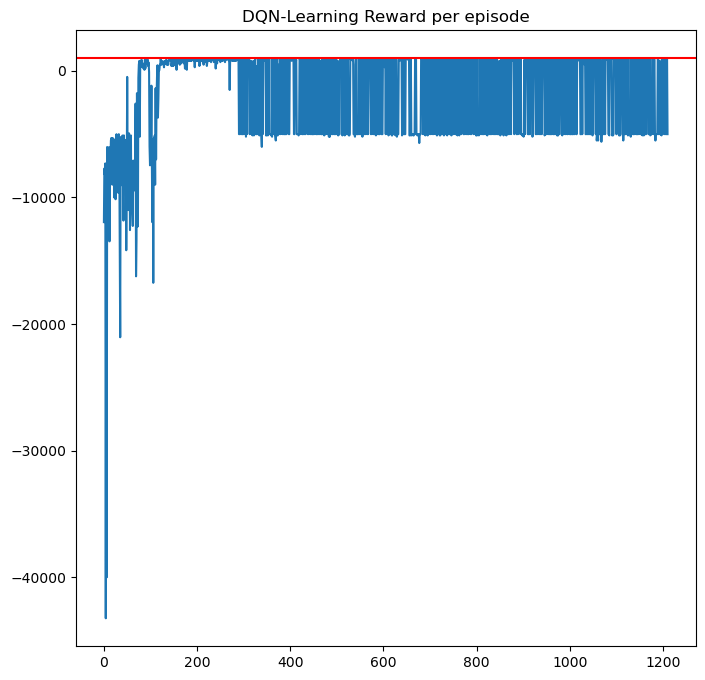

In [44]:
plt.plot(dqn_maze_agent_2.reward_per_episode)
plt.axhline(1000, color = 'r', label = '100')
plt.title("DQN-Learning Reward per episode");

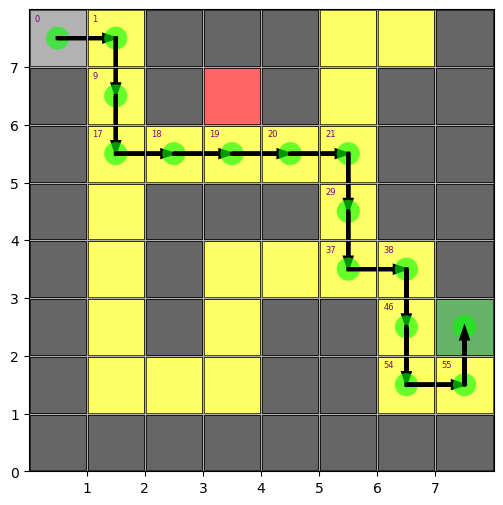

In [45]:
dqn_maze_agent_2.plot_policy()

In [46]:
dqn_maze_env_3 = MazeEnvironment(maze)
dqn_maze_agent_3 = DQN_MazeAgent(dqn_maze_env_3, 0.95)

start = time.time()
dqn_maze_agent_3.run_episodes(s=400, episode_max_length=10000, total_episodes=1500)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Episodes number 0. Epsilon = 1.000
Episodes number 100. Epsilon = 0.917, Average duration: 0:00:00.307310
Episodes number 200. Epsilon = 0.740, Average duration: 0:00:00.193935
Episodes number 300. Epsilon = 0.536, Average duration: 0:00:00.112809
Episodes number 400. Epsilon = 0.355, Average duration: 0:00:00.121804
Episodes number 500. Epsilon = 0.222, Average duration: 0:00:00.058019
Episodes number 600. Epsilon = 0.140, Average duration: 0:00:00.062573
Episodes number 700. Epsilon = 0.097, Average duration: 0:00:00.038795
Episodes number 800. Epsilon = 0.077, Average duration: 0:00:00.043195
Episodes number 900. Epsilon = 0.069, Average duration: 0:00:00.032607
Episodes number 1000. Epsilon = 0.067, Average duration: 0:00:00.032538
Episodes number 1100. Epsilon = 0.066, Average duration: 0:00:00.036507
Episodes number 1200. Epsilon = 0.066, Average duration: 0:00:00.032096
Episodes number 1300. Epsilon = 0.066, Average duration: 0:00:00.032388
Episodes number 1400. Epsilon = 0.066,

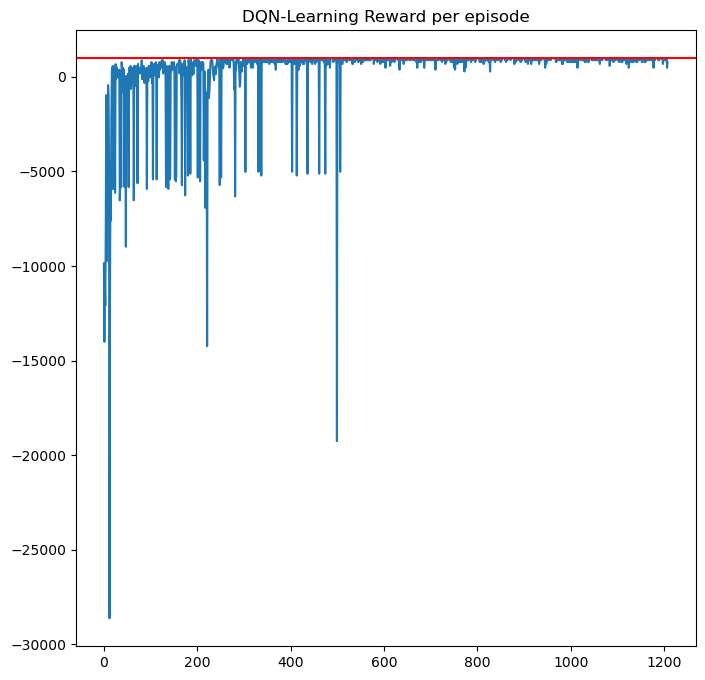

In [47]:
plt.plot(dqn_maze_agent_3.reward_per_episode)
plt.axhline(1000, color = 'r', label = '100')
plt.title("DQN-Learning Reward per episode");

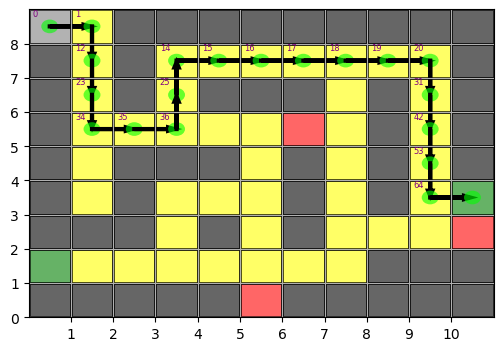

In [48]:
dqn_maze_agent_3.plot_policy()

In [49]:
dqn_maze_env_4 = MazeEnvironment(maze, 0.6)
dqn_maze_agent_4 = DQN_MazeAgent(dqn_maze_env_4, 0.95)

start = time.time()
dqn_maze_agent_4.run_episodes(s=450, episode_max_length=10000, total_episodes=2000)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Episodes number 0. Epsilon = 1.000
Episodes number 100. Epsilon = 0.933, Average duration: 0:00:00.095992
Episodes number 200. Epsilon = 0.785, Average duration: 0:00:00.073114
Episodes number 300. Epsilon = 0.605, Average duration: 0:00:00.099844
Episodes number 400. Epsilon = 0.431, Average duration: 0:00:00.238829
Episodes number 500. Epsilon = 0.290, Average duration: 0:00:00.482423
Episodes number 600. Epsilon = 0.190, Average duration: 0:00:00.597609
Episodes number 700. Epsilon = 0.128, Average duration: 0:00:00.124343
Episodes number 800. Epsilon = 0.094, Average duration: 0:00:00.041583
Episodes number 900. Epsilon = 0.077, Average duration: 0:00:00.050759
Episodes number 1000. Epsilon = 0.070, Average duration: 0:00:00.049685
Episodes number 1100. Epsilon = 0.067, Average duration: 0:00:00.042430
Episodes number 1200. Epsilon = 0.066, Average duration: 0:00:00.040074
Episodes number 1300. Epsilon = 0.066, Average duration: 0:00:00.039650
Episodes number 1400. Epsilon = 0.066,

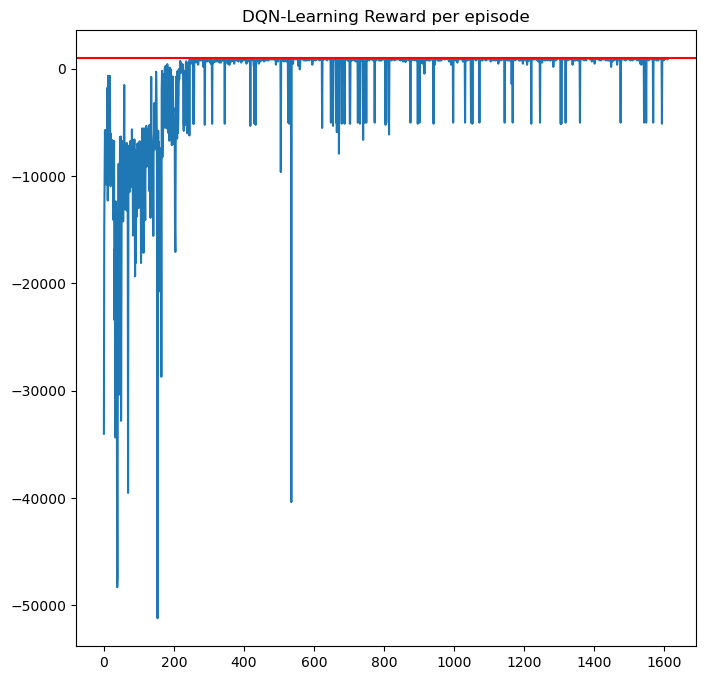

In [50]:
plt.plot(dqn_maze_agent_4.reward_per_episode)
plt.axhline(1000, color = 'r', label = '100')
plt.title("DQN-Learning Reward per episode");

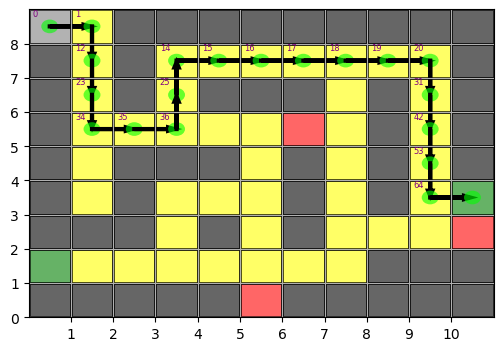

In [51]:
dqn_maze_agent_4.plot_policy()

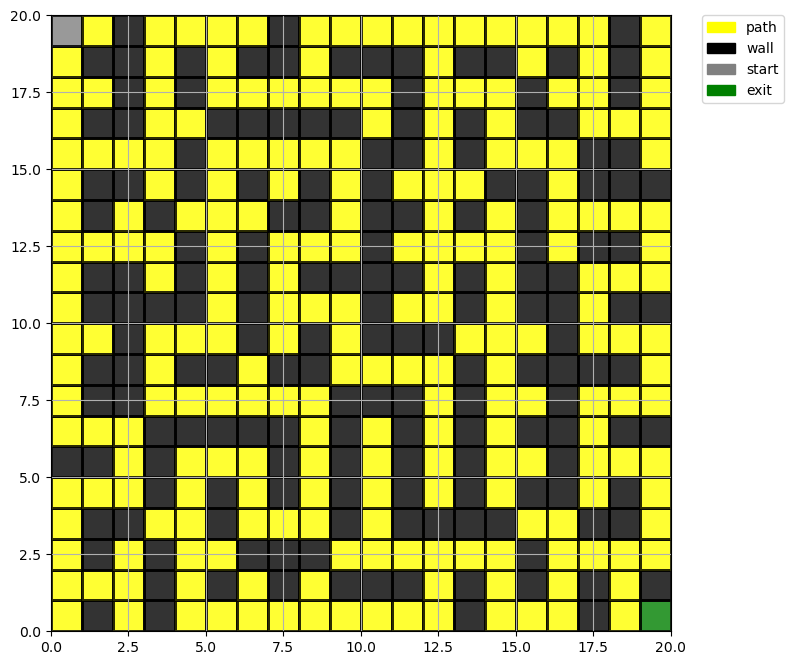

In [211]:
complex_maze = Maze([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 
                     [0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0], 
                     [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0], 
                     [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0], 
                     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0], 
                     [0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1], 
                     [0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0], 
                     [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0], 
                     [0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0], 
                     [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1], 
                     [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0], 
                     [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0], 
                     [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0], 
                     [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1], 
                     [1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], 
                     [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0], 
                     [0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0], 
                     [0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
                     [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1], 
                     [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]])

complex_maze.set_start([0,0])
complex_maze.set_exit([(19,19)])

complex_maze.show()

In [811]:
dqn_maze_env_5 = MazeEnvironment(complex_maze)
dqn_maze_agent_5 = DQN_MazeAgent(dqn_maze_env_5, 0.95)

start = time.time()
dqn_maze_agent_5.run_episodes(s=2000, episode_max_length=5000, total_episodes=5500)
end = time.time()
print(f"Total elapsed time: {timedelta(seconds=end-start)}")

Episodes number 0. Epsilon = 1.000
Episodes number 100. Epsilon = 0.995, Average duration: 0:00:05.037159
Episodes number 200. Epsilon = 0.984, Average duration: 0:00:05.197970
Episodes number 300. Epsilon = 0.967, Average duration: 0:00:04.594425
Episodes number 400. Epsilon = 0.946, Average duration: 0:00:05.293451
Episodes number 500. Epsilon = 0.920, Average duration: 0:00:05.199707
Episodes number 600. Epsilon = 0.891, Average duration: 0:00:04.356428
Episodes number 700. Epsilon = 0.859, Average duration: 0:00:05.345466
Episodes number 800. Epsilon = 0.825, Average duration: 0:00:04.308507
Episodes number 900. Epsilon = 0.788, Average duration: 0:00:04.617868
Episodes number 1000. Epsilon = 0.749, Average duration: 0:00:04.062063
Episodes number 1100. Epsilon = 0.710, Average duration: 0:00:04.429069
Episodes number 1200. Epsilon = 0.669, Average duration: 0:00:05.620338
Episodes number 1300. Epsilon = 0.628, Average duration: 0:00:02.940810
Episodes number 1400. Epsilon = 0.588,

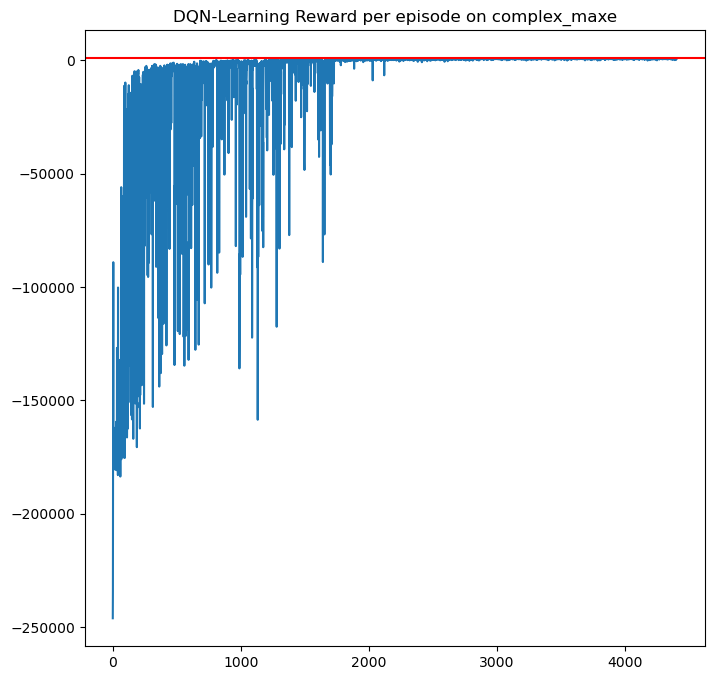

In [812]:
plt.plot(dqn_maze_agent_5.reward_per_episode)
plt.axhline(1000, color = 'r', label = '100')
plt.title("DQN-Learning Reward per episode on complex_maxe");

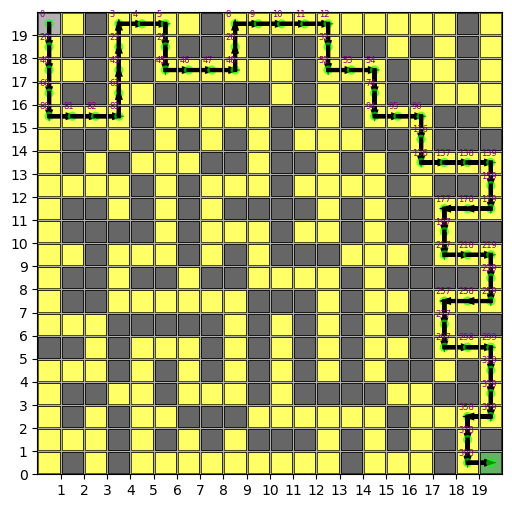

In [813]:
dqn_maze_agent_5.plot_policy()

In [13]:
from sklearn import preprocessing as pre
from sklearn.kernel_approximation import RBFSampler

$\phi (s,a)$ is a feature vector or function that maps states and actions to real-valued features



In [425]:
class GP_MazeAgent(MazeAgent):
    def __init__(self, maze_env: MazeEnvironment, lr=0.1, n_components=30):
        super().__init__(maze_env)
        self.lr = lr
        self.samples = []
        self.n_components = n_components
        self.featurizer = RBFSampler(n_components = self.n_components)
        self.theta = None
        self.one_hot_encoded_action = np.eye(len(self.maze_env.actions))
        self.pi = self.boltzmann
        
    def epsilon_greedy(self, s, eps):
        return np.random.choice(self.maze_env.actions)

    def softmax(self, s):
        phi_s_b_theta = []
        for b in self.maze_env.actions:
            s_b = self.merge_s_a(s, b)
            phi_s_b = self.featurizer.transform([s_b])[0]
            phi_s_b_theta.append(phi_s_b @ self.theta)
        phi_s_b_theta = np.array(phi_s_b_theta).reshape(-1, 1)
        phi_s_b_theta_normalized = pre.MinMaxScaler().fit_transform(phi_s_b_theta).reshape(-1)
        exp_phi_s_b_theta = np.exp(phi_s_b_theta_normalized) + 0.0001 # prevent underflow
        return exp_phi_s_b_theta / np.sum(exp_phi_s_b_theta)
        
    def boltzmann(self, s=None, tau=1):
        if s == None:
            s = self.maze_env.get_state()
        softmax = self.softmax(s)    
        return np.random.choice(self.maze_env.actions, p=softmax)
    
    def merge_s_a(self, s, a):
        # Get the actions's index
        a_idx = self.maze_env.actions.index(a)
        # Get the one-shot encoded action
        encoded_action = self.one_hot_encoded_action[a_idx]
        s = np.array([s])
        return np.concatenate((s, encoded_action))
        
    def gather_samples(self, total_episodes=1000):
        self.samples = []
        weights = np.ones(len(self.non_exit_states))
        for episodes in range(total_episodes):
            self.reset()
            weights = self.reset_episode(weights, episodes, total_episodes)
            # Run an episode
            while (self.maze_env.game_over == False):
                self.take_action(self.epsilon_greedy) # Take a random action
                (s, a), r = self.episode[-1]
                sa = self.merge_s_a(s, a)
                self.samples.append(sa)

    def fit(self, total_episodes=500):
        self.gather_samples(total_episodes)
        self.featurizer.fit(self.samples)
        # initialize linear model weights
        self.theta = np.zeros(self.n_components)
        # self.theta = np.random.rand(self.n_components)

    def predict(self, s, a):
        s_a = self.merge_s_a(s, a)
        phi_s_a = self.featurizer.transform([s_a])[0]
        return phi_s_a @ self.theta
 
    def predict_actions(self, s=None):
        if s == None:
            s = self.maze_env.get_state()
        return [self.predict(s, a) for a in self.maze_env.actions]
        
    def gradient(self, s, a):
        s_a = self.merge_s_a(s, a)
        phi_s_a = self.featurizer.transform([s_a])[0]
        phi_s = []
        phi_s_theta = []
        for b in self.maze_env.actions:
            s_b = self.merge_s_a(s, b)
            phi_s_b = self.featurizer.transform([s_b])[0]
            phi_s.append(phi_s_b)
            phi_s_b_theta = phi_s_b @ self.theta
            phi_s_theta.append(phi_s_b_theta)
        phi_s = np.array(phi_s)
        phi_s_theta = np.array(phi_s_theta).reshape(-1, 1)
        phi_s_theta_normalized = pre.MinMaxScaler().fit_transform(phi_s_theta).reshape(-1)
        exp_phi_s_theta = np.exp(phi_s_theta_normalized) + 0.0001 # prevent underflow
        exp_phi_s_theta = exp_phi_s_theta.reshape(-1,1)
        numerator = phi_s * exp_phi_s_theta
        sm = np.sum((phi_s * exp_phi_s_theta), 0)
        sm /= np.sum(exp_phi_s_theta)
        step = phi_s_a - sm
        return step
    
    def run_episodes(self, episode_max_length=500, total_episodes=1000):
        # Make sure fit was done
        assert self.theta is not None
        
        self.reset()
        episodes = 0
        self.reward_per_episode = []
        weights = np.ones(len(self.non_exit_states)) # weights for the selection of the start state
        
        while episodes != total_episodes:
            
            if episodes % 100 == 0:
                print(f"Episodes number {episodes}.")

            # Reset for an episode
            #weights = self.reset_episode(weights, episodes, total_episodes)
            # Reset for an episode (start in the 'start' position)
            self.maze_env.reset()
            self.episode = []
            
            # Run an episode
            episode_reward = 0
            current_episode_counter = episode_max_length
            while (self.maze_env.game_over == False) and current_episode_counter:
                current_episode_counter -=1
                self.take_action(self.pi)
                _, r = self.episode[-1]
                episode_reward += r

            # Update the policy parameters
            for t, ((s,a), r) in enumerate(self.episode):
                #print(f"t = {t}. s = {s}, a = {a}, r = {r}")
                futur_reward = [r*self.gamma**(t+i) for i, (_,r) in enumerate(self.episode[t:])]
                G = np.sum(futur_reward)
                log_grad = self.gradient(s, a)
                self.theta += self.lr * G * log_grad
            
            self.reward_per_episode.append(episode_reward)       
            episodes += 1
            
        for state in self.non_exit_states:
            v = self.softmax(state)
            #print(f"v({state}) = {v}")
            self.policy[state] = self.maze_env.actions[np.argmax(v)]

           

In [175]:
%%script false --no-raise-error
# The previous line is to deactivate this cell

ridiculous_maze = Maze([[0,0,1],
                       [1,0,0],
                       [1,1,1]])

ridiculous_maze.set_start([0,0])
ridiculous_maze.set_exit([(1,2)])
#ridiculous_maze.show()

In [426]:
#gp_maze_env = MazeEnvironment(ridiculous_maze)
gp_maze_env = MazeEnvironment(small_maze)
gp_maze_agent = GP_MazeAgent(gp_maze_env, lr=0.05, n_components=100)
gp_maze_agent.set_gamma(0.99)

print(f"Computing the feature map")
gp_maze_agent.fit()
print(f"Ready")

Computing the feature map
Ready


In [434]:
print("Start")
start = time.time()
gp_maze_agent.run_episodes(episode_max_length=2000, total_episodes=2500)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Start
Episodes number 0.
Episodes number 100.
Episodes number 200.
Episodes number 300.
Episodes number 400.
Episodes number 500.
Episodes number 600.
Episodes number 700.
Episodes number 800.
Episodes number 900.
Episodes number 1000.
Episodes number 1100.
Episodes number 1200.
Episodes number 1300.
Episodes number 1400.
Episodes number 1500.
Episodes number 1600.
Episodes number 1700.
Episodes number 1800.
Episodes number 1900.
Episodes number 2000.
Episodes number 2100.
Episodes number 2200.
Episodes number 2300.
Episodes number 2400.
Elapsed time: 0:04:02.785673


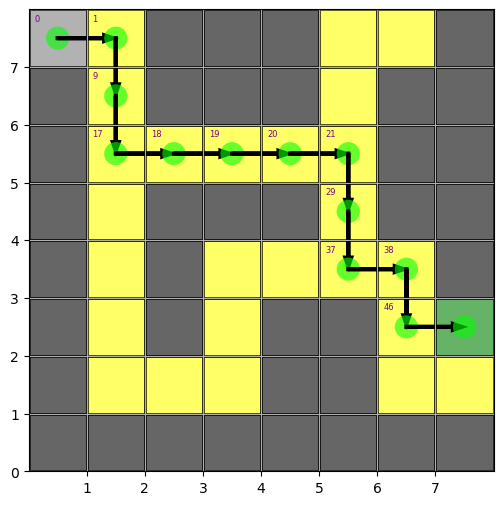

In [435]:
gp_maze_agent.plot_policy()

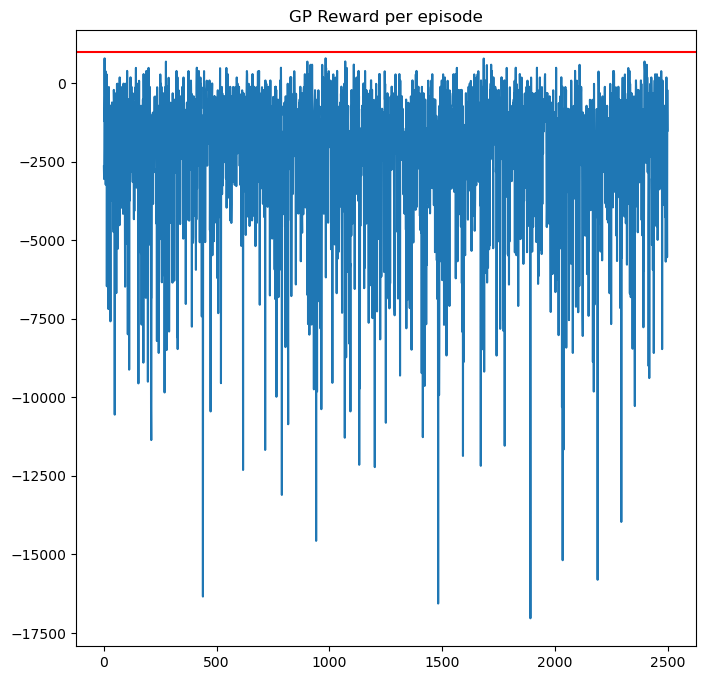

In [436]:
plt.plot(gp_maze_agent.reward_per_episode)
plt.axhline(1000, color = 'r', label = '100')
plt.title("GP Reward per episode");

In [437]:
gp2_maze_env = MazeEnvironment(maze)
gp2_maze_agent = GP_MazeAgent(gp2_maze_env, lr=0.05, n_components=100)
gp2_maze_agent.set_gamma(0.99)

print(f"Computing the feature map")
gp2_maze_agent.fit()
print(f"Ready")
print("Start")
start = time.time()
gp2_maze_agent.run_episodes(episode_max_length=3000, total_episodes=3700)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Computing the feature map
Ready
Start
Episodes number 0.
Episodes number 100.
Episodes number 200.
Episodes number 300.
Episodes number 400.
Episodes number 500.
Episodes number 600.
Episodes number 700.
Episodes number 800.
Episodes number 900.
Episodes number 1000.
Episodes number 1100.
Episodes number 1200.
Episodes number 1300.
Episodes number 1400.
Episodes number 1500.
Episodes number 1600.
Episodes number 1700.
Episodes number 1800.
Episodes number 1900.
Episodes number 2000.
Episodes number 2100.
Episodes number 2200.
Episodes number 2300.
Episodes number 2400.
Episodes number 2500.
Episodes number 2600.
Episodes number 2700.
Episodes number 2800.
Episodes number 2900.
Episodes number 3000.
Episodes number 3100.
Episodes number 3200.
Episodes number 3300.
Episodes number 3400.
Episodes number 3500.
Episodes number 3600.
Elapsed time: 0:09:42.518360


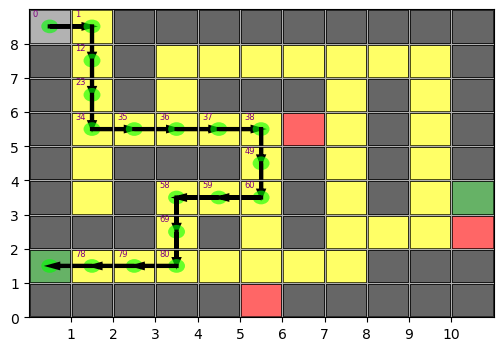

In [438]:
gp2_maze_agent.plot_policy()

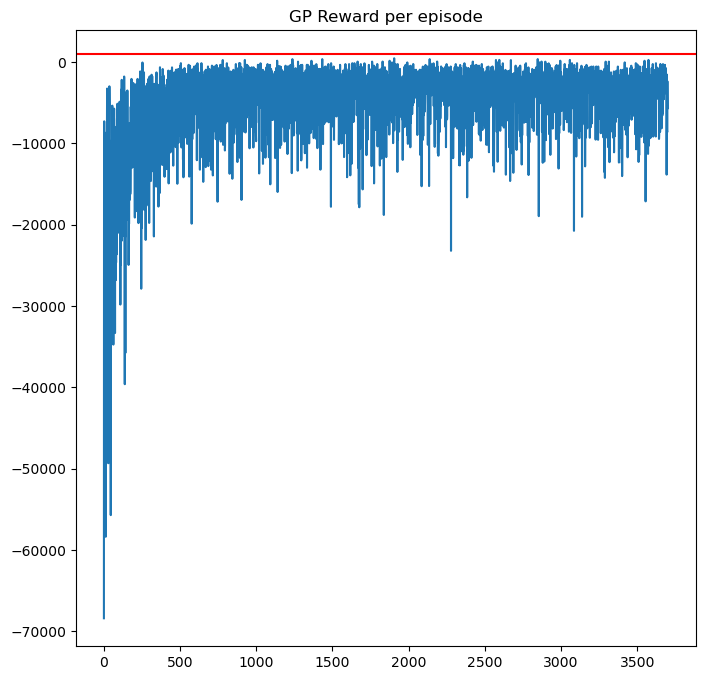

In [439]:
plt.plot(gp2_maze_agent.reward_per_episode)
plt.axhline(1000, color = 'r', label = '100')
plt.title("GP Reward per episode");

In [359]:
class AC_MazeAgent(MazeAgent):
    def __init__(self, maze_env: MazeEnvironment, w_lr=0.1, theta_lr=0.1, s_n_components=100, sa_n_components=100):
        super().__init__(maze_env)
        self.w_lr = w_lr
        self.theta_lr = theta_lr
        self.samples = []
        self.s_n_components = s_n_components
        self.sa_n_components = sa_n_components
        self.s_featurizer = RBFSampler(n_components = self.s_n_components)
        self.sa_featurizer = RBFSampler(n_components = self.sa_n_components)
        self.theta = None
        self.w = None
        self.one_hot_encoded_action = np.eye(len(self.maze_env.actions))
        self.pi = self.boltzmann
        
    def epsilon_greedy(self, s, eps=1):
        return np.random.choice(self.maze_env.actions)

    def softmax(self, s):
        phi_s_b_theta = []
        for b in self.maze_env.actions:
            s_b = self.merge_s_a(s, b)
            phi_s_b = self.sa_featurizer.transform([s_b])[0]
            phi_s_b_theta.append(phi_s_b @ self.theta)
        phi_s_b_theta = np.array(phi_s_b_theta).reshape(-1, 1)
        phi_s_b_theta_normalized = pre.MinMaxScaler().fit_transform(phi_s_b_theta).reshape(-1)
        exp_phi_s_b_theta = np.exp(phi_s_b_theta_normalized) + 0.0001 # prevent underflow
        return exp_phi_s_b_theta / np.sum(exp_phi_s_b_theta)
        
    def boltzmann(self, s=None, tau=1):
        if s == None:
            s = self.maze_env.get_state()
        softmax = self.softmax(s)    
        return np.random.choice(self.maze_env.actions, p=softmax)
    
    def merge_s_a(self, s, a):
        # Get the actions's index
        a_idx = self.maze_env.actions.index(a)
        # Get the one-shot encoded action
        encoded_action = self.one_hot_encoded_action[a_idx]
        s = np.array([s])
        return np.concatenate((s, encoded_action))
        
    def gather_samples(self, total_episodes=1000):
        self.samples = []
        weights = np.ones(len(self.non_exit_states))
        for episodes in range(total_episodes):
            self.reset()
            weights = self.reset_episode(weights, episodes, total_episodes)
            # Run an episode
            while (self.maze_env.game_over == False):
                self.take_action(self.epsilon_greedy) # Take a random action
                (s, a), r = self.episode[-1]
                sa = self.merge_s_a(s, a)
                self.samples.append(sa)

    def fit(self, total_episodes=500):
        self.gather_samples(total_episodes)
        self.sa_featurizer.fit(self.samples)
        s_samples = [arr[0] for arr in self.samples]
        s_samples = np.array(s_samples).reshape(-1, 1)
        self.s_featurizer.fit(s_samples)
        # initialize linear models weights
        self.theta = np.zeros(self.sa_n_components)
        self.w = np.zeros(self.s_n_components)

    def predict(self, s, a):
        s_a = self.merge_s_a(s, a)
        phi_s_a = self.featurizer.transform([s_a])[0]
        return phi_s_a @ self.theta
 
    def predict_actions(self, s=None):
        if s == None:
            s = self.maze_env.get_state()
        return [self.predict(s, a) for a in self.maze_env.actions]

    def gradient_v(self, state):
        s = self.s_featurizer.transform(np.array([state]).reshape(-1,1))[0]
        return s
        
    def gradient_log_pi(self, s, a):
        s_a = self.merge_s_a(s, a)
        phi_s_a = self.sa_featurizer.transform([s_a])[0]
        phi_s = []
        phi_s_theta = []
        for b in self.maze_env.actions:
            s_b = self.merge_s_a(s, b)
            phi_s_b = self.sa_featurizer.transform([s_b])[0]
            phi_s.append(phi_s_b)
            phi_s_b_theta = phi_s_b @ self.theta
            phi_s_theta.append(phi_s_b_theta)
        phi_s = np.array(phi_s)
        phi_s_theta = np.array(phi_s_theta).reshape(-1, 1)
        phi_s_theta_normalized = pre.MinMaxScaler().fit_transform(phi_s_theta).reshape(-1)
        exp_phi_s_theta = np.exp(phi_s_theta_normalized) + 0.0001 # prevent underflow
        exp_phi_s_theta = exp_phi_s_theta.reshape(-1,1)
        numerator = phi_s * exp_phi_s_theta
        sm = np.sum((phi_s * exp_phi_s_theta), 0)
        sm /= np.sum(exp_phi_s_theta)
        step = phi_s_a - sm
        return step

    def get_v(self, state):
        s = self.s_featurizer.transform(np.array([state]).reshape(-1,1))[0]
        return s @ self.w
        
    def run_episodes(self, episode_max_length=500, total_episodes=1000):
        # Make sure fit was done
        assert self.theta is not None
        
        self.reset()
        episodes = 0
        self.reward_per_episode = []
        weights = np.ones(len(self.non_exit_states)) # weights for the selection of the start state
        
        while episodes != total_episodes:
            
            if episodes % 100 == 0:
                print(f"Episodes number {episodes}.")

            # Reset for an episode
            #weights = self.reset_episode(weights, episodes, total_episodes)
            # Reset for an episode (start in the 'start' position)
            self.maze_env.reset()
            self.episode = []
            
            # Run an episode
            episode_reward = 0
            states_actions = []
            #i = 1
            while (self.maze_env.game_over == False): 
                #if episodes == 0:
                #    self.take_action(self.epsilon_greedy, 1) # Take a random action
                #else:
                self.take_action(self.pi)
                (s,a), r = self.episode[-1]
                episode_reward += r

                #if (s, a) not in states_actions:
                #states_actions.append((s, a)) # "First Visit"
            
                # Update the policy parameters
                #print(f"t = {t}. s = {s}, a = {a}, r = {r}")
                if self.maze_env.game_over == True:
                    delta = r - self.get_v(s)
                else:
                    s_prim = self.maze_env.get_state()
                    delta = r + self.gamma * self.get_v(s_prim) - self.get_v(s)
                grad_log_pi = self.gradient_log_pi(s, a)
                grad_v = self.gradient_v(s)
                self.w += self.w_lr * delta * grad_v
                #self.theta += self.theta_lr * i * delta * grad_log_pi
                self.theta += self.theta_lr * delta * grad_log_pi
                #i *= self.gamma
                #print(f"G = {G}, log_grad = {log_grad}")
            
            self.reward_per_episode.append(episode_reward)       
            episodes += 1
            #print(f"Episode {episodes} length: {current_episode_counter}. G = {episode_reward}")
            
        for state in self.non_exit_states:
            v = self.softmax(state)
            self.policy[state] = self.maze_env.actions[np.argmax(v)]

           

In [382]:
ac_maze_env = MazeEnvironment(maze)
ac_maze_agent = AC_MazeAgent(ac_maze_env, w_lr=0.05, theta_lr=0.01, s_n_components=100, sa_n_components=100)
ac_maze_agent.set_gamma(0.99)

print(f"Computing the feature map")
ac_maze_agent.fit()
print(f"Ready")

Computing the feature map
Ready


In [383]:
print("Start")
start = time.time()
ac_maze_agent.run_episodes(episode_max_length=2000, total_episodes=4500)
end = time.time()
print(f"Elapsed time: {timedelta(seconds=end-start)}")

Start
Episodes number 0.
Episodes number 100.
Episodes number 200.
Episodes number 300.
Episodes number 400.
Episodes number 500.
Episodes number 600.
Episodes number 700.
Episodes number 800.
Episodes number 900.
Episodes number 1000.
Episodes number 1100.
Episodes number 1200.
Episodes number 1300.
Episodes number 1400.
Episodes number 1500.
Episodes number 1600.
Episodes number 1700.
Episodes number 1800.
Episodes number 1900.
Episodes number 2000.
Episodes number 2100.
Episodes number 2200.
Episodes number 2300.
Episodes number 2400.
Episodes number 2500.
Episodes number 2600.
Episodes number 2700.
Episodes number 2800.
Episodes number 2900.
Episodes number 3000.
Episodes number 3100.
Episodes number 3200.
Episodes number 3300.
Episodes number 3400.
Episodes number 3500.
Episodes number 3600.
Episodes number 3700.
Episodes number 3800.
Episodes number 3900.
Episodes number 4000.
Episodes number 4100.
Episodes number 4200.
Episodes number 4300.
Episodes number 4400.
Elapsed time: 0:

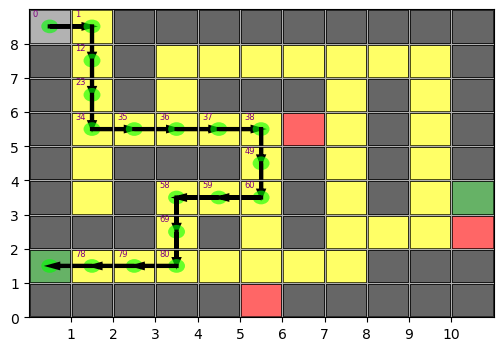

In [385]:
ac_maze_agent.plot_policy()

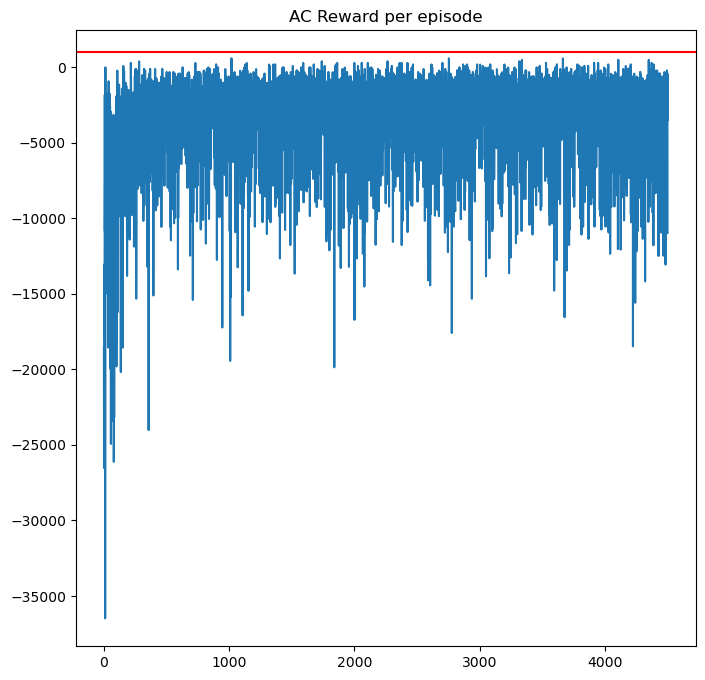

In [387]:
plt.plot(ac_maze_agent.reward_per_episode)
plt.axhline(1000, color = 'r', label = '100')
plt.title("AC Reward per episode");